In [2]:
import PIL
import os
import tensorflow as tf
import numpy as np
import pandas
from skimage.io import imread
from tensorflow.keras import layers, Input, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import zipfile

c:\Users\timka\anaconda3\envs\tektim_model\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
directory_path = 'test_set'

In [4]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    image_size=(256, 256),  # Resize images to 256x256
    batch_size=32,  # Number of images to return in each batch
    label_mode='categorical',  # Can be 'int', 'categorical', or 'binary'
    validation_split=0.2,
    subset='training',
    seed=42
)

Found 2023 files belonging to 2 classes.
Using 1619 files for training.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory_path,
    image_size=(256, 256),  # Resize images to 256x256
    batch_size=32,  # Number of images to return in each batch
    label_mode='categorical',  # Can be 'int', 'categorical', or 'binary'
    validation_split=0.2,
    subset='validation',
    seed=42
)

Found 2023 files belonging to 2 classes.
Using 404 files for validation.


In [6]:
class_names = train_ds.class_names
class_names

['cats', 'dogs']

In [7]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(256,256,3),
    pooling='avg',
    classes=3
)
 
for layer in pretrained_model.layers:
    layer.trainable = False
    
resnet_model.add(pretrained_model)
#resnet_model.add(layers.Flatten())
resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.Dense(2, activation='softmax'))

In [8]:
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                                 
Total params: 24637826 (93.99 MB)
Trainable params: 1050114 (4.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [10]:
# check if trained raw model exists
if not os.path.exists('dogcat.keras'):
    # if zipped model doesnt exist as well, train the model and save raw model and zip raw model
    if not os.path.exists('dogcat_zip.zip'):
        history = resnet_model.fit(
            train_ds,
            validation_data=test_ds,
            epochs=10
        )
        # saving the model
        resnet_model.save('dogcat.keras')
        # zipping the model
        with zipfile.ZipFile('dogcat_zip.zip', 'w', zipfile.ZIP_DEFLATED) as zip:
            zip.write('dogcat.keras')
    # otherwise, zip exists and can unzip the model
    else:
        with zipfile.ZipFile('dogcat_zip.zip', 'r') as zip:
            for file_info in zip.infolist():
                if file_info.filename.endswith('dogcat.keras'):
                    file_info.filename = os.path.basename(file_info.filename) # extract only the filename
                    zip.extract(file_info, 'data/models/raw')
# load the trained model
imported_model = tf.keras.models.load_model('dogcat.keras')

In [11]:
from tensorflow.keras.preprocessing import image

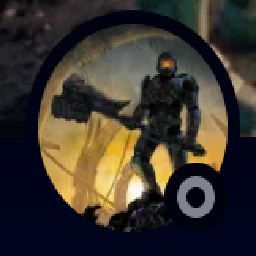

In [12]:
img = image.load_img('Screenshot 2024-12-10 035652.png', target_size=(256, 256))
img_arr = image.img_to_array(img)
img_arr = np.expand_dims(img_arr, axis=0)
img

In [13]:
preds = imported_model.predict(img_arr)
preds

1/1 [==============================] - 1s 884ms/step


array([[0.07849125, 0.9215087 ]], dtype=float32)

In [14]:
print('Predicted class is', class_names[np.argmax(preds)])

Predicted class is dogs


In [16]:
import joblib

joblib.dump(class_names, 'class_names.pkl')

['class_names.pkl']